In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
import os
from utils.SHIPS_preprocess import SHIPS_train_test_split, calc_d24_VMAX, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS
from utils.SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes
from utils.SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_RF
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_RF, get_scores_best_params_RF, create_gridsearch_RF, get_train_test_split
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_LR, get_scores_best_params_LR, create_gridsearch_LR, get_feature_importances_LR
from utils.SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score
from sklearn.inspection import permutation_importance
import matplotlib.colors
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from utils.SHIPS_ML_model_funcs_imblearn import create_gridsearch_RF_sampler
from utils import SHIPS_plotting

### Reliability Diagram

In this script, we compare our machine learning model predictions of rapid intensification (RI) against our existing baseline forecast (in this case, it's the SHIPS-RII consensus and the RII model based on linear discriminant analysis), as well as our observed RI frequencies.  We need to load the probabilistic RI forecasts as well as the best-tracks (our observations/truth).  We present the comparison in the form of a reliability diagram, which will compare the predicted frequency of RI to the observed frequency. 

##### Load predicted classes from our ML models

In [3]:
fpath_load = 'DATA/ML_model_results/TESTING/all_models_ROS_and_SMOTE/'
yr_start = 2005
train_yr_end = 2018
yr_end_LOAD = 2021
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
scoring = 'f1_weighted'
save_extension = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_MASK_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=yr_start,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)
#
y_pred_ML = pd.read_csv(fpath_load+'PREDICTED_Y_vals'+save_extension)

Keep only Atlantic and East Pacific cases

In [4]:
y_pred_sel = y_pred_ML[y_pred_ML['Predicted Basin'].isin(['ATLANTIC','EAST_PACIFIC'])]
# Relabel I_class as Y_true
y_pred_sel['Y true'] = y_pred_sel['I_class']

/tmp/ipykernel_879084/521206864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_sel['Y true'] = y_pred_sel['I_class']


#### Now, load our probabilistic RI forecasts (e-decks) and the best-track forecasts (b-decks)

In [5]:
yr_sel = [2019,2020,2021]
best_track = pd.DataFrame()
e_deck = pd.DataFrame()
for iyr in yr_sel:
    print('loading ',iyr)
    ibest = pd.read_csv('VALIDATION_data/processed/best_tracks_{iyr}.csv'.format(iyr=iyr))
    iprob = pd.read_csv('VALIDATION_data/edecks/etracks_RI_{iyr}.csv'.format(iyr=iyr))
    #
    if iyr != 2019:
        e_deck = e_deck.append(iprob)
        best_track = best_track.append(ibest)
    elif iyr == 2019:
        best_track = best_track.append(ibest)
        iprob = pd.read_csv('VALIDATION_data/processed/SHIPS_RII_rapid_intense_probs_{iyr}.csv'.format(iyr=iyr))
        edeck_2019 = iprob
#
e_deck = e_deck.drop(columns={'Initials','Unnamed: 0'})
# Select best-track for radius of maximum winds = 34 km (?) 
best_track = best_track[best_track['RAD']==34]

loading  2019
loading  2020
loading  2021


##### Make some changes to basin and date formatting

In [6]:
e_deck['ATCF BASIN'] = e_deck['BASIN']
e_deck['ATCF BASIN'] = e_deck['ATCF BASIN'].replace('ATLANTIC','AL',regex=True)
e_deck['ATCF BASIN'] = e_deck['ATCF BASIN'].replace('EAST_PACIFIC','EP',regex=True)
e_deck['ATCF BASIN'] = e_deck['ATCF BASIN'].replace('CENTRAL_PACIFIC','CP',regex=True)
#
e_deck['ATCF Year'] = pd.to_datetime(e_deck['DATE']).dt.year
e_deck['ATCF ID'] = e_deck['ATCF BASIN'] + e_deck['CYCLONE NO'].astype(str) + e_deck['ATCF Year'].astype(str)
e_deck['ATCF BASIN'] + e_deck['CYCLONE NO'].astype(str)

0         ALC7
1         ALC7
2         ALC7
3         ALC7
4         ALC7
          ... 
102687    AL13
102688    AL13
102689    AL13
102690    AL13
102691    AL13
Length: 247600, dtype: object

##### For the e-decks, 2019 is formatted slightly differently than 2020/2021, so we make some adjustments

In [7]:
edeck_2019
edeck_2019 = edeck_2019.drop(columns={'Unnamed: 0'})
edeck_2019 = edeck_2019.rename(columns={'Cyclone No':'CYCLONE NO','Date':'DATE','d_I':'Intensity Change',
                                       'V_final':'V','RI start time':'RIstartTAU','RI end time':'RIstopTAU',
                                       'LAT_0':'LAT','LON_0':'LON','RI Type':'Tech'})

In [8]:
edeck_2019['Tech'].unique()

array(['RIOB', 'Consensus', 'RIOD', 'RII', nan], dtype=object)

#### Selecting RI threshold and combine e-decks
We want the probability of RI of at least 30 knots in 24 hours.  So for the e-decks, select the `ProbItem` that corrresponds to this threshhold. 

Then we'll combine our e-decks from 2019 (different format) to 2020/2021.  We'll keep only 2019 forecasts that are SHIPS-RII with linear discriminant analysis (`RIOL`) and the RI consensus (`RIOC`)

In [9]:
e_deck = e_deck.rename(columns={'ProbItem':'30/24'})
# 
edeck_2019 = edeck_2019[edeck_2019['Tech'].isin(['RII','Consensus'])]
edeck_2019['Tech'] = edeck_2019['Tech'].replace({'RII':'RIOD','Consensus':'RIOC'})
edecks_ALL = pd.concat([edeck_2019,e_deck])

##### Get 24-hour changes in VMAX for best tracks
Get 24-hour changes in VMAX. Mask out cases where `Timedelta > 1 Day` (aka, going from one case to another). 

In [10]:
best_track['BASIN'] = best_track['BASIN'].replace({'EP':'EAST_PACIFIC','AL':'ATLANTIC'})
ships = best_track.set_index(['BASIN','CYCLONE NO','NAME','TIME'])#.sort_values(['DATE'])
init_hr = 0 
nlev = ships.index.nlevels
SHIPS_t0 = ships
SHIPS_t24 = SHIPS_t0.shift(-4)
pred_num = ['VMAX','MSLP']
date_diff = pd.to_datetime(SHIPS_t24['DATE']) - pd.to_datetime(SHIPS_t0['DATE'])
diff = SHIPS_t24[['VMAX','MSLP']] -  SHIPS_t0[['VMAX','MSLP']]
diff = diff.where(date_diff == pd.Timedelta(1,'D'))#
best_track_diffs = ships.copy()
best_track_diffs[['d24_VMAX','d24_MSLP']] = diff[['VMAX','MSLP']]
best_track_diffs['DATE_full'] = best_track_diffs['DATE']
#best_track_diffs['DATE'] = pd.to_datetime(best_track_diffs['DATE']).dt.strftime('%Y-%m-%d')

##### Bin e-deck RI probabilities by 10s 
Round the e-deck RI probabilities to the nearest 10. (RI probability of 0-5 will go into 5% bin). We identify the desired intensity change, and determine the probability of RI ($ProbItem$) at that intensity change ($Intensity Chnage$).  Also make sure we are at the 24 hour threshold ($RIstartTAU = 0$, $RIstopTAU = 24$). 

Then, we will find corresponding best tracks for each probability bin.  We will count up the number of days that actually saw RI. 

In [11]:
RI_thresh = 30
tech_sel = ['RIOD','RIOC']
e_decks_trim = edecks_ALL.where((edecks_ALL['RIstartTAU']==0) & (edecks_ALL['RIstopTAU']==24)).dropna(how='all')
e_decks_trim = e_decks_trim[e_decks_trim['Tech'].isin(tech_sel)]
#e_decks_trim = e_decks_trim.rename(columns={'Tech':'Model'})
e_decks_trim = e_decks_trim[e_decks_trim['Intensity Change']==RI_thresh]
#
e_decks_trim['Prob. RI'] = e_decks_trim['30/24'].round(-1)
e_decks_trim['Prob. RI'] = e_decks_trim['Prob. RI'].mask(e_decks_trim['30/24'] <= 5, 5)
#
e_decks_trim['TIME'] = pd.to_datetime(e_decks_trim['DATE']).dt.hour
e_decks_trim['DATE'] = pd.to_datetime(e_decks_trim['DATE']).dt.date
e_decks_trim['DATE_full'] = pd.to_datetime(e_decks_trim['DATE']) + pd.to_timedelta(e_decks_trim['TIME'],'hours')

##### Reliability for e-decks

In [12]:
pct_range = e_decks_trim['Prob. RI'].unique().tolist()
reliability_edecks = pd.DataFrame()
#
models_sel = ['RIOC','RIOD']
# i_model = 'RIOD'
#ipct = 10
for i_model in models_sel:
    i_e_decks_trim = e_decks_trim.set_index(['Tech']).xs(i_model).reset_index()
    for ipct in pct_range:
        if not ipct in i_e_decks_trim.set_index(['Prob. RI']).index:
            continue
        else:
            edeck_sel = i_e_decks_trim.set_index(['Prob. RI','BASIN','CYCLONE NO','DATE','TIME']).xs(ipct)
            best_track_diffs['DATE'] = pd.to_datetime(best_track_diffs['DATE'])
            bdeck_sel = best_track_diffs.reset_index().set_index(['BASIN','CYCLONE NO','DATE','TIME'])
            bdeck_sel['Y true'] = 0
            bdeck_sel['Y true'] = bdeck_sel['Y true'].mask(bdeck_sel['d24_VMAX']>= RI_thresh,1)
            b_ind = bdeck_sel.index.to_list()
            e_ind = edeck_sel.index.to_list()
            ind_both = set(b_ind)&set(e_ind)
            #
            bdeck_trim = bdeck_sel.loc[ind_both]
            edeck_trim = edeck_sel.loc[ind_both]
            total_days = edeck_trim.reset_index().groupby(['BASIN']).count()
            no_RI = bdeck_trim.groupby(['BASIN'])['Y true'].sum()
            # pct = 100*(no_RI/total_days)
            #
            i_df = pd.DataFrame(index=total_days.index,columns={'Observed Pct','Predicted Pct'})
            # 
            if len(no_RI) == 0:
                pct = 0
                i_df['Observed Pct'] = 0
                i_df['Observed No. RI'] = 0
            else:
                pct = 100*(no_RI/total_days['V'])
                i_df['Observed Pct'] = pct
                i_df['Observed No. RI'] = no_RI
            #
            i_df['Predicted Pct'] = ipct
            i_df['Observed No Total'] = total_days['V']
            i_df['Model'] = i_model
            reliability_edecks = reliability_edecks.append(i_df)
    ###

In [13]:
reliability_edecks

,Predicted Pct,Observed Pct,Observed No. RI,Observed No Total,Model
BASIN,,,,,
ATLANTIC,5.0,0.000000,0,96,RIOC
EAST_PACIFIC,5.0,0.000000,0,41,RIOC
ATLANTIC,10.0,2.439024,1,41,RIOC
EAST_PACIFIC,10.0,0.000000,0,12,RIOC
ATLANTIC,20.0,13.333333,2,15,RIOC
EAST_PACIFIC,20.0,0.000000,0,5,RIOC
ATLANTIC,30.0,0.000000,0,9,RIOC
EAST_PACIFIC,30.0,66.666667,2,3,RIOC
ATLANTIC,40.0,100.000000,1,1,RIOC


In [14]:
reliability_edecks['Model'] = reliability_edecks['Model'].replace('RIOC','Consensus')
reliability_edecks['Model'] = reliability_edecks['Model'].replace('RIOD','SHIPS-RII')
edeck_sel = i_e_decks_trim.set_index(['Prob. RI','BASIN','CYCLONE NO','DATE','TIME'])#.xs(ipct)

In [15]:
edeck_sel = i_e_decks_trim.set_index(['Prob. RI','BASIN','CYCLONE NO','DATE','TIME'])#.xs(ipct)

In [16]:
reliability_edecks['Model'].unique()

array(['Consensus', 'SHIPS-RII'], dtype=object)

#### Prepare ML data

In [17]:
y_pred_sel['Y pred probab (class: 1)'] = y_pred_sel['Y pred probab (class: 1)']*100
# Round for bins
y_pred_sel['RI prob'] = (y_pred_sel['Y pred probab (class: 1)']).round(-1)
# Anything less than or equal to 5 becomes 5
y_pred_sel['RI prob'] = y_pred_sel['RI prob'].mask(y_pred_sel['RI prob'] <= 5, 5)
#
pct_range = y_pred_sel['RI prob'].unique().tolist()
reliability = pd.DataFrame()
for ipct in pct_range:
    # ipct = 10
    if ipct == 100:
        continue
    y_sel = y_pred_sel.set_index(['RI prob']).xs(ipct)
    total = y_sel.groupby(['Predicted Basin','Model']).count()
    RI = y_sel[y_sel['Y true']==1].groupby(['Predicted Basin','Model']).count()
    i_df = pd.DataFrame(index=total.index,columns={'Observed Pct','Predicted Pct'})
    if len(RI) == 0:
        pct = 0
        i_df['Observed Pct'] = 0
        i_df['Observed No. RI'] = 0
    else:
        pct = 100*(RI/total)
        i_df['Observed Pct'] = pct['CASE']
        i_df['Observed No. RI'] = RI['CASE']
    i_df['Predicted Pct'] = ipct
    i_df['Observed No Total'] = total['CASE']
    reliability = reliability.append(i_df)

/tmp/ipykernel_879084/4083976669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_sel['Y pred probab (class: 1)'] = y_pred_sel['Y pred probab (class: 1)']*100
/tmp/ipykernel_879084/4083976669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_sel['RI prob'] = (y_pred_sel['Y pred probab (class: 1)']).round(-1)
/tmp/ipykernel_879084/4083976669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [18]:
pct_range

[10.0, 70.0, 30.0, 60.0, 40.0, 5.0, 50.0, 20.0, 80.0, 90.0]

#### Prepare for plotting

In [19]:
reliability = reliability.mask(reliability.isna(),0)
basin_ALL = reliability.reset_index()['Predicted Basin'].unique().tolist()

In [20]:
reliability_edecks = reliability_edecks.reset_index().rename(columns={'BASIN':'Predicted Basin'}).set_index(['Predicted Basin','Model'])
reliability_ALL = pd.concat([reliability,reliability_edecks])

#### Create consensus forecast with RF model.  
We'll pick one random forest model to use for our RF/RII consensus (`consensus_sel`). The other two RF models will be included in `models_skip`, as we will refrain from plotting the total number of cases per predicted RI probability (we'll still plot the actual lines, just not the numbers). 

In [34]:
# Pick RF model 
consensus_sel = 'Random Forest (random oversample)'
models_skip = ['Random Forest (class wt)','Random Forest (ROS)']
#
RF_consensus = reliability_ALL.xs((consensus_sel),level=1).reset_index().sort_values('Predicted Pct')
RF_consensus = RF_consensus[RF_consensus['Predicted Basin'].isin(['ATLANTIC','EAST_PACIFIC'])]
RF_consensus = RF_consensus.set_index(['Predicted Basin','Predicted Pct'])
RF_consensus.loc[('EAST_PACIFIC',5),:] = 0
## And now get SHIPS-RII consensus
RII_consensus = reliability_ALL.xs(('SHIPS-RII'),level=1).reset_index().set_index(['Predicted Basin','Predicted Pct'])
RF_RII_consensus = pd.concat((RF_consensus.replace(0,np.nan),RII_consensus.replace(0,np.nan))).mean(level=(0,1))
RF_RII_consensus = RF_RII_consensus.reset_index().set_index(['Predicted Basin'])
reliability_edecks

,,Predicted Pct,Observed Pct,Observed No. RI,Observed No Total
Predicted Basin,Model,,,,
ATLANTIC,Consensus,5.0,0.000000,0,96
EAST_PACIFIC,Consensus,5.0,0.000000,0,41
ATLANTIC,Consensus,10.0,2.439024,1,41
EAST_PACIFIC,Consensus,10.0,0.000000,0,12
ATLANTIC,Consensus,20.0,13.333333,2,15
EAST_PACIFIC,Consensus,20.0,0.000000,0,5
ATLANTIC,Consensus,30.0,0.000000,0,9
EAST_PACIFIC,Consensus,30.0,66.666667,2,3
ATLANTIC,Consensus,40.0,100.000000,1,1


In [35]:
# Reliability diagram plotting parameters
plot_lim = 115.5
palette = sns.color_palette(sns.xkcd_palette(['royal purple','coral','turquoise','tangerine','leaf green',
                                             'goldenrod']))


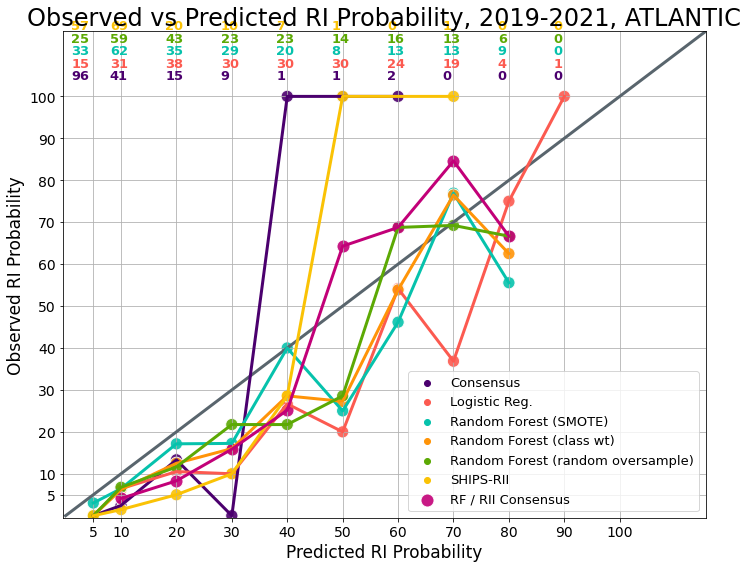

In [36]:
basin_sel = 'ATLANTIC'

fig1,ax1 = plt.subplots(1,1,figsize=(10,8))
SHIPS_plotting.make_reliability_diagram(ax1,plot_lim,reliability_ALL,basin_sel,palette,pct_range,models_skip)
sns.scatterplot(data=RF_RII_consensus.xs(basin_sel),x='Predicted Pct',y='Observed Pct',color='xkcd:magenta',ax=ax1,
                s=170,alpha=0.9,label='RF / RII Consensus')
sns.lineplot(data=RF_RII_consensus.xs(basin_sel).reset_index(),x='Predicted Pct',y='Observed Pct',
              color='xkcd:magenta',ax=ax1,linewidth=3,legend=False)
ax1.legend(fontsize=13,loc='lower right')
ax1.set_title('Observed vs Predicted RI Probability, 2019-2021, {basin_sel}'.format(basin_sel=basin_sel),fontsize=24)
fig1.tight_layout()
fig1.savefig('Figures/TESTING/reliability_obs_vs_pred_{basin_sel}_2019-2021.pdf'.format(basin_sel=basin_sel),
            format='pdf',bbox_inches='tight')
fig1.savefig('Figures/TESTING/reliability_obs_vs_pred_{basin_sel}_2019-2021.png'.format(basin_sel=basin_sel),
            format='png',dpi=350,bbox_inches='tight')

##### Version for NSF review


In [37]:
reliability_sel = reliability_ALL.reset_index()[reliability_ALL.reset_index()['Model'].isin(['Logistic Reg.','Random Forest (SMOTE)',
                                                                                            'Consensus','SHIPS-RII'])]
reliability_sel = reliability_sel.set_index(['Predicted Basin','Model'])

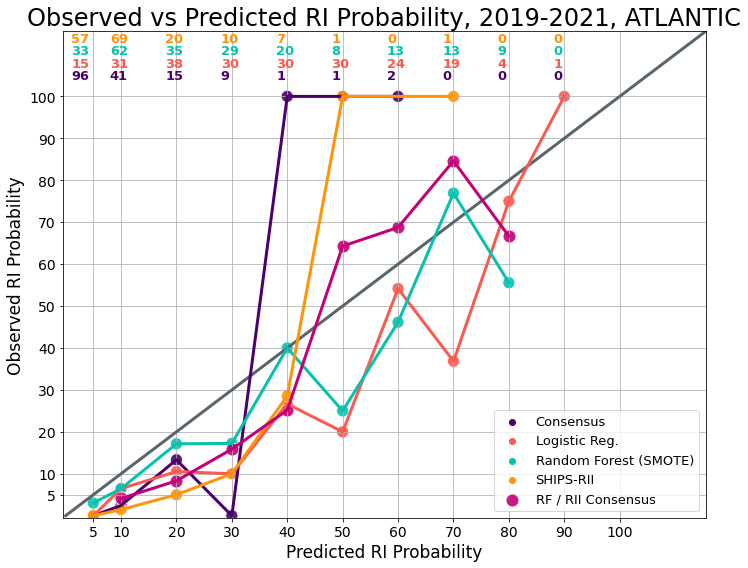

In [38]:
basin_sel = 'ATLANTIC'

fig1,ax1 = plt.subplots(1,1,figsize=(10,8))
SHIPS_plotting.make_reliability_diagram(ax1,plot_lim,reliability_sel,basin_sel,palette,pct_range,models_skip)
sns.scatterplot(data=RF_RII_consensus.xs(basin_sel),x='Predicted Pct',y='Observed Pct',color='xkcd:magenta',ax=ax1,
                s=170,alpha=0.9,label='RF / RII Consensus')
sns.lineplot(data=RF_RII_consensus.xs(basin_sel).reset_index(),x='Predicted Pct',y='Observed Pct',
              color='xkcd:magenta',ax=ax1,linewidth=3,legend=False)
ax1.legend(fontsize=13,loc='lower right')
ax1.set_title('Observed vs Predicted RI Probability, 2019-2021, {basin_sel}'.format(basin_sel=basin_sel),fontsize=24)
fig1.tight_layout()
#fig1.savefig('Figures/TESTING/reliability_obs_vs_pred_{basin_sel}_2019-2021.pdf'.format(basin_sel=basin_sel),
  #          format='pdf',bbox_inches='tight')
fig1.savefig('Figures/TESTING/NSF_REVIEW_reliability_obs_vs_pred_{basin_sel}_2019-2021.png'.format(basin_sel=basin_sel),
  format='png',dpi=350,bbox_inches='tight')

##### East Pacific

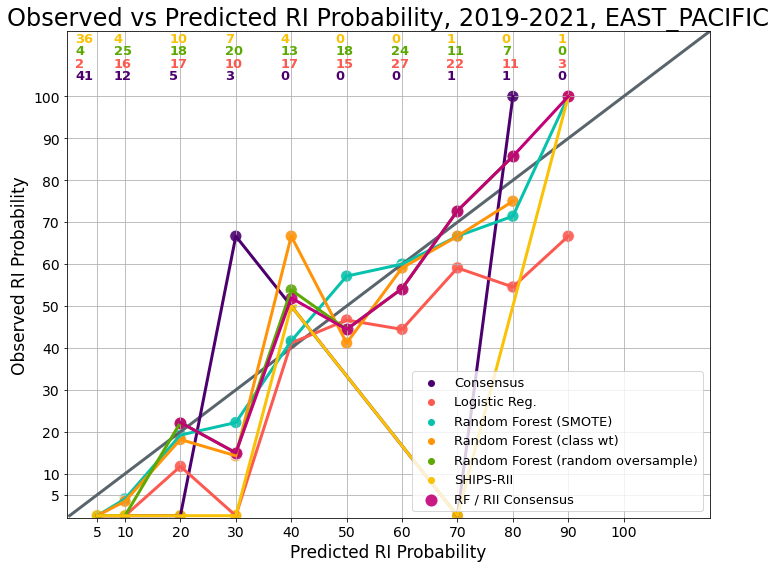

In [24]:
basin_sel = 'EAST_PACIFIC'
fig1,ax1 = plt.subplots(1,1,figsize=(10,8))
#foo = reliability_ALL.xs('Random Forest (SMOTE)',level=1)
# foo = reliability_ALL.reset_index()[reliability_ALL.reset_index()['Model'].isin(['Random Forest (SMOTE)',
#                                 'Logistic Reg.','Random Forest (random oversample)'])].set_index(['Predicted Basin'])
#
SHIPS_plotting.make_reliability_diagram(ax1,plot_lim,reliability_ALL,basin_sel,palette,pct_range,models_skip)
sns.scatterplot(data=RF_RII_consensus.xs(basin_sel),x='Predicted Pct',y='Observed Pct',color='xkcd:magenta',ax=ax1,
                s=170,alpha=0.9,label='RF / RII Consensus')
sns.lineplot(data=RF_RII_consensus.xs(basin_sel).reset_index(),x='Predicted Pct',y='Observed Pct',
              color='xkcd:magenta',ax=ax1,linewidth=3,legend=False)
ax1.legend(fontsize=13,loc='lower right')
ax1.set_title('Observed vs Predicted RI Probability, 2019-2021, {basin_sel}'.format(basin_sel=basin_sel),fontsize=24)
fig1.tight_layout()
fig1.savefig('Figures/TESTING/reliability_obs_vs_pred_{basin_sel}_2019-2021.pdf'.format(basin_sel=basin_sel),
            format='pdf',bbox_inches='tight')
fig1.savefig('Figures/TESTING/reliability_obs_vs_pred_{basin_sel}_2019-2021.png'.format(basin_sel=basin_sel),
            format='png',dpi=350,bbox_inches='tight')

Reliability diagram--both in one figure

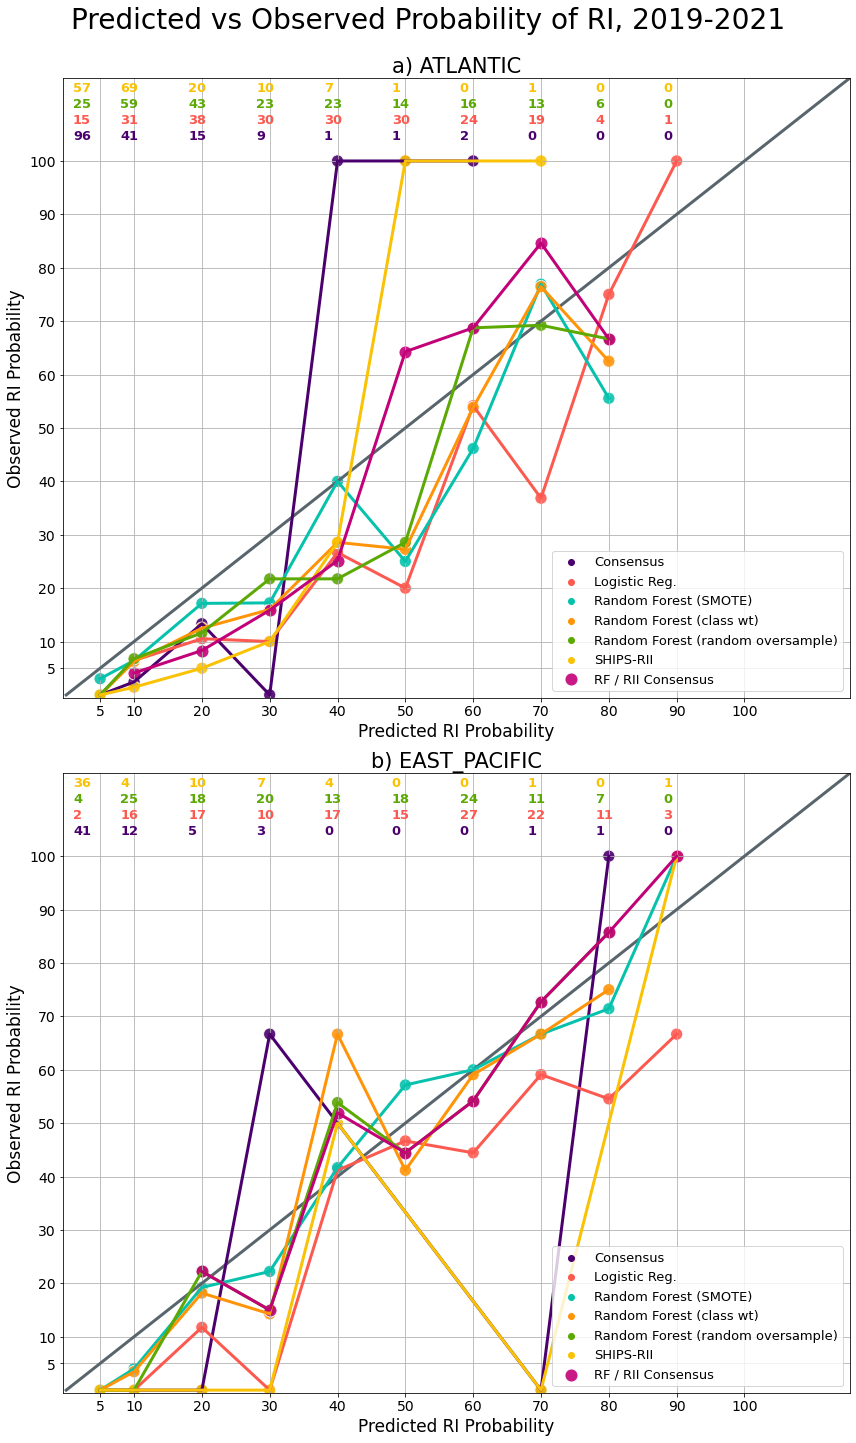

In [25]:
fig2,(ax2a,ax2b) = plt.subplots(2,1,figsize=(12,20))
# Since all three RF models have similar numbers of cases per predicted probability, only plot whichever one we are 
# using for the RF/RII consensus
# Panel a
basin_sel = 'ATLANTIC'
SHIPS_plotting.make_reliability_diagram(ax2a,plot_lim,reliability_ALL,basin_sel,palette,pct_range,models_skip)
# Add RF/RII consensus
sns.scatterplot(data=RF_RII_consensus.xs(basin_sel),x='Predicted Pct',y='Observed Pct',color='xkcd:magenta',ax=ax2a,
                s=170,alpha=0.9,label='RF / RII Consensus')
sns.lineplot(data=RF_RII_consensus.xs(basin_sel).reset_index(),x='Predicted Pct',y='Observed Pct',
              color='xkcd:magenta',ax=ax2a,linewidth=3,legend=False)
ax2a.legend(fontsize=13,loc='lower right')
ax2a.set_title('a) {basin_sel}'.format(basin_sel=basin_sel),fontsize=21)
# Panel b
basin_sel = 'EAST_PACIFIC'
SHIPS_plotting.make_reliability_diagram(ax2b,plot_lim,reliability_ALL,basin_sel,palette,pct_range,models_skip)
# Add RF/RII consensus
sns.scatterplot(data=RF_RII_consensus.xs(basin_sel),x='Predicted Pct',y='Observed Pct',color='xkcd:magenta',ax=ax2b,
                s=170,alpha=0.9,label='RF / RII Consensus')
sns.lineplot(data=RF_RII_consensus.xs(basin_sel).reset_index(),x='Predicted Pct',y='Observed Pct',
              color='xkcd:magenta',ax=ax2b,linewidth=3,legend=False)
ax2b.legend(fontsize=13,loc='lower right')
ax2b.set_title('b) {basin_sel}'.format(basin_sel=basin_sel),fontsize=21)
#
fig2.suptitle('Predicted vs Observed Probability of RI, 2019-2021',y=1,fontsize=28)
fig2.tight_layout()
fig2.savefig('Figures/TESTING/reliability_obs_vs_pred_allpanels_2019-2021.pdf',
            format='pdf',bbox_inches='tight')
fig2.savefig('Figures/TESTING/reliability_obs_vs_pred_allpanels_2019-2021.png',
            format='png',dpi=350,bbox_inches='tight')